In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from typing import Callable, Dict, List, Tuple

# Report

### Names

Ethan Pedersen

### Abstract

I implemented code to model complex contagion, given the parameters from the project specs (a = 3 and b = 2).  As I went through the various test cases, I found that, while the clustering coefficient of a graph can be a good indicator for how well complex contagion spreads, other factors, such as which nodes are early adopters or strong ties vs. weak ties, can also have a significant impact on spread.

### Introduction

I found this problem to be interesting because Dr. Crandall's lab works with a social interaction game (JHG; if Dr. Goodrich is grading this, then I'm pretty sure you're familiar with it).  I personally haven't done much work with the JHG, but I've found the aspect of how influence from clusters of players can sometimes spread to be interesting.  Furthermore, I'm teaching CS 470 this semester; we've discussed information cascades, but with a Bayesian approach, so it was fun to play around with a graph version.

My report for project 1 felt disjointed, so this time I'm treating the vast majority of this notebook as the report.  You can skip through the code cells if you wish; the markdown cells contain my hypotheses, discussion points, etc.  The remainder of this report/notebook is structured as follows:

<ul>
    <li> Helper Code: This section contains the majority of the code I used to run the simulations, generate plots and tables, etc.  You can skip through this (unless you want to admire my mediocre code).
    <li> Figure 19.4: This contains the results for the network from Figure 19.4 of the textbook; you can also skip this (it was just for my own benefit).
    <li> Circulant, 20-2: The hypotheses, tests, results/plots, discussion, etc. for the circulant 20-2 network.
    <li> Circulant, 20-4: The hypotheses, tests, results/plots, discussion, etc. for the circulant 20-4 network.
    <li> Karate: The hypotheses, tests, results/plots, discussion, etc. for the karate network.
    <li> Small World, 100: The hypotheses, tests, results/plots, discussion, etc. for the small world 100 network.
    <li> Scale-Free, 100: The hypotheses, tests, results/plots, discussion, etc. for the scale-free 100 network.
    <li> Small World, 410: The hypotheses, tests, results/plots, discussion, etc. for the small world 410 network.
    <li> Scale-Free, 410: The hypotheses, tests, results/plots, discussion, etc. for the scale-free 410 network.
    <li> Dublin: The hypotheses, tests, results/plots, discussion, etc. for the Dublin network.
    <li> Summary Plots (For the Large Networks): Contains several summary plots for the larger networks.
    <li> Summary Table (For the Large Networks): Contains a summary table for the larger networks.
    <li> Future Work: A brief description on what I would work on next and what I wish I had done differently.
</ul>

Note that, for the smaller graphs, the specs say to "consider presenting a sequence of screen shots that show how the cascade spreads over the network."  This sounded a lot like an animation to me, so I generated animations for the small networks.  Whenever I display an animation, you should see the final result of the graph on the top, with the animation of spread on the bottom.  For consistency purposes, I used 20 iterations when running all of my simulations.  This means that you might need to wait a few seconds for the gif to reset to the beginning of the animation (i.e. during the final time steps there is no more spread, so the animation looks static).

### Helper Code

In [2]:
# Generic state class
class State:
    def __init__(self, color: str) -> None:
        self.color = color

    def transition(self):
        pass

    def utility(self) -> int:
        pass


# State A
class A(State):
    def __init__(self, color: str = 'cyan') -> None:
        super().__init__(color)

    def transition(self) -> State:
        return self
    
    def utility(self) -> int:
        return 3
    

# State B
class B(State):
    def __init__(self, neighbors: List, color: str = 'blue') -> None:
        super().__init__(color)
        self.neighbors = neighbors

    def transition(self) -> State:
        cumulative_a, cumulative_b = 0, 0

        for neighbor in self.neighbors:
            neighbor_utility = neighbor.prev_state.utility()
            cumulative_a += neighbor_utility if isinstance(neighbor.prev_state, A) else 0
            cumulative_b += neighbor_utility if isinstance(neighbor.prev_state, B) else 0

        return A() if cumulative_a >= cumulative_b else self
    
    def utility(self) -> int:
        return 2

In [3]:
# Agent class (used to represent each node in a graph)
class Agent:
    def __init__(self, initial_state_type: type) -> None:
        assert issubclass(initial_state_type, State)
        self.initial_state_type = initial_state_type
        self.neighbors = []
        self.prev_state, self.curr_state = None, None

    def transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state
        self.curr_state = self.curr_state.transition()

    def finalize_transition(self) -> None:
        assert self.curr_state is not None
        self.prev_state = self.curr_state

    def add_neighbor(self, neighbor) -> None:
        self.neighbors.append(neighbor)

    def set_initial_state(self) -> None:
        self.curr_state = self._initialize_state()
        self.prev_state = self.curr_state

    def _initialize_state(self) -> State:
        if self.initial_state_type == B:
            return B(neighbors=self.neighbors)
        
        else:
            return A()

In [4]:
# Population class (used to create and handle agents for a graph)
class Population:
    def __init__(self, graph_generator: Callable[[None], nx.Graph], 
                 early_adopters_generator: Callable[[nx.Graph], List[object]]) -> None:
        self.graph_generator = graph_generator
        self.graph = self.graph_generator()
        self.early_adopters_generator = early_adopters_generator
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

    def _initialize_agents(self) -> Dict:
        agents, nodes = {}, self.graph.nodes

        for node in nodes:
            if node in self.early_adopters:
                initial_state_type = A

            else:
                initial_state_type = B

            agents[node] = Agent(initial_state_type)

        for node in nodes:
            neighbors = self.graph.neighbors(node)

            for neighbor in neighbors:
                neighbor_agent = agents[neighbor]
                agents[node].add_neighbor(neighbor_agent)

            agents[node].set_initial_state()

        return agents
    
    def transition(self) -> None:
        # Calculate what each node's next state should be
        for agent in self.agents.values():
            agent.transition()

        # Apply/set the next states
        for agent in self.agents.values():
            agent.finalize_transition()
    
    def n_agents_with_type(self, state_type: type) -> int:
        assert issubclass(state_type, State)

        n_with_type = 0

        for agent in self.agents.values():
            n_with_type += 1 if isinstance(agent.curr_state, state_type) else 0

        return n_with_type
    
    def nodes_with_type(self, state_type: type) -> List[Tuple[object, str]]:
        nodes_with_type = [(node_label, agent.curr_state.color) for node_label, agent 
                           in self.agents.items() if isinstance(agent.curr_state, state_type)]
        
        return nodes_with_type
    
    def reset(self) -> None:
        self.graph = self.graph_generator()
        self.early_adopters = self.early_adopters_generator(self.graph)
        self.agents = self._initialize_agents()

In [5]:
# Simulation class (used to run simulations on a population and track results)
class Simulation:
    def __init__(self, name: str, population: Population, layout: Dict, n_iterations: int = 20, n_trials: int = 1) -> None:
        self.name = name
        self.population = population
        self.layout = layout
        self.n_iterations = n_iterations
        self.n_trials = n_trials
        self.a_counts, self.b_counts = [], []

    def run(self, animate: bool = False) -> None:
        node_colors = []
        self.a_counts, self.b_counts = [], []
        self.clustering_coefficients, self.times_to_stop, self.agent_percentages = [], [], []

        for _ in range(self.n_trials):
            a_counts, b_counts = [], []

            for _ in range(self.n_iterations):
                for state_type, count_array in [(A, a_counts), (B, b_counts)]:
                    n_agents_with_type = self.population.n_agents_with_type(state_type)
                    count_array.append(n_agents_with_type)

                if animate and len(node_colors) < self.n_iterations:
                    colors = []

                    for state_type in [A, B]:
                        nodes_with_type = self.population.nodes_with_type(state_type)
                        colors.extend(nodes_with_type)

                    node_colors.append(colors)

                self.population.transition()

            # Keep track of the two states
            self.a_counts.append(a_counts)
            self.b_counts.append(b_counts)

            # Reset the population for the next trial (if there is a next trial)
            self.population.reset()

        if animate:
            print('Done with simulations; animating...')
            graph = self.population.graph
            fig = plt.figure()

            def update(frame: int) -> None:
                color_mapping = {}
                colors = node_colors[frame]

                for node, color in colors:
                    color_mapping[node] = color

                nx.draw(graph, self.layout, with_labels=True, node_color=[color_mapping[node] for node in graph.nodes])

            ani = FuncAnimation(fig, update, frames=self.n_iterations, repeat=False)
            ani.save(f'./project_2_animations/animation_{self.name}.gif', writer='imagemagick', fps=0.5)

        return

    def plot(self, show_iqr: bool = False) -> None:
        assert len(self.a_counts) == len(self.b_counts) == self.n_trials
        assert len(self.a_counts[0]) == len(self.b_counts[0]) == self.n_iterations

        x_vals = range(self.n_iterations)

        a_mean = np.mean(self.a_counts, axis=0)
        plt.plot(x_vals, a_mean, label='A', color='cyan')
        b_mean = np.mean(self.b_counts, axis=0)
        plt.plot(x_vals, b_mean, label='B', color='blue')

        if show_iqr:
            a_25 = np.percentile(self.a_counts, 25, axis=0)
            a_75 = np.percentile(self.a_counts, 75, axis=0)
            plt.fill_between(x_vals, a_25, a_75, color='cyan', alpha=0.5)
            b_25 = np.percentile(self.b_counts, 25, axis=0)
            b_75 = np.percentile(self.b_counts, 75, axis=0)
            plt.fill_between(x_vals, b_25, b_75, color='blue', alpha=0.5)

        plt.legend(loc='best')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.title('Number of Nodes in the A and B States, Over Time')
        plt.show()

In [70]:
def time_to_stop(counts: List[int], tolerance: float = 0.05) -> int:
    prev_val = None

    for i, val in enumerate(counts):
        if prev_val is None:
            prev_val = val
            continue

        if abs(val - prev_val) <= tolerance:
            return i + 1
        
        prev_val = val
        
    return len(counts)

In [75]:
def plots_for_larger_graphs(simulations: List[Simulation]) -> None:
    clustering_coefficients, times_to_stop, agent_percentages = [], [], []
    average_degrees, densities = [], []

    for simulation in simulations:   
        times, percentages = [], []
        graph, a_counts = simulation.population.graph, simulation.a_counts

        for counts in a_counts:
            times.append(time_to_stop(counts))
            percentages.append(counts[-1] / graph.number_of_nodes())

        time_to_stop_avg = (sum(times) / len(times))
        agent_percentages_avg = sum(percentages) / len(percentages)
        clustering_coefficients.append(nx.average_clustering(graph))
        times_to_stop.append(time_to_stop_avg)
        agent_percentages.append(agent_percentages_avg)
        average_degrees.append(sum(dict(graph.degree()).values()) / len(graph))
        densities.append(nx.density(graph))
        

    # Time to stop as a function of clustering coefficient
    sorted_pairs = sorted(zip(clustering_coefficients, times_to_stop))
    coeffs, times = zip(*sorted_pairs)
    plt.scatter(coeffs, times)
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('Time to Stop')
    plt.title('Time for Cascade to Stop as a Function of Clustering Coefficient')
    plt.show()

    # Percent of A nodes as a function of clustering coefficient
    sorted_pairs = sorted(zip(clustering_coefficients, agent_percentages))
    coeffs, percentages = zip(*sorted_pairs)
    plt.scatter(coeffs, percentages)
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('Percent')
    plt.title('Percent of Nodes that Adopted A as a Function of Clustering Coefficient')
    plt.show()

    # Time to stop as a function of average degree
    sorted_pairs = sorted(zip(average_degrees, times_to_stop))
    coeffs, times = zip(*sorted_pairs)
    plt.scatter(coeffs, times)
    plt.xlabel('Average Degree')
    plt.ylabel('Time to Stop')
    plt.title('Time for Cascade to Stop as a Function of Average Degree')
    plt.show()

    # Percent of A nodes as a function of average degree
    sorted_pairs = sorted(zip(average_degrees, agent_percentages))
    coeffs, percentages = zip(*sorted_pairs)
    plt.scatter(coeffs, percentages)
    plt.xlabel('Average Degree')
    plt.ylabel('Percent')
    plt.title('Percent of Nodes that Adopted A as a Function of Average Degree')
    plt.show()

    # Time to stop as a function of density
    sorted_pairs = sorted(zip(densities, times_to_stop))
    coeffs, times = zip(*sorted_pairs)
    plt.scatter(coeffs, times)
    plt.xlabel('Density')
    plt.ylabel('Time to Stop')
    plt.title('Time for Cascade to Stop as a Function of Density')
    plt.show()

    # Percent of A nodes as a function of density
    sorted_pairs = sorted(zip(densities, agent_percentages))
    coeffs, percentages = zip(*sorted_pairs)
    plt.scatter(coeffs, percentages)
    plt.xlabel('Density')
    plt.ylabel('Percent')
    plt.title('Percent of Nodes that Adopted A as a Function of Density')
    plt.show()

In [72]:
def summary_table(simulations: List[Simulation], decimal_places: int = 3) -> None:
    rows = []
    column_headers = ['Graph', 'Time to Stop, 25th Percentile', 'Time to Stop, Average', 'Time to Stop, 75th Percentile', 
                      'Adoption Percentage, 25th Percentile', 'Adoption Percentage, Average', 
                      'Adoption Percentage, 75th Percentile', 'Clustering Coefficient', 'Average Degree', 'Density']

    for simulation in simulations:
        times_to_stop, agent_percentages = [], []
        graph, a_counts = simulation.population.graph, simulation.a_counts

        for counts in a_counts:
            times_to_stop.append(time_to_stop(counts))
            agent_percentages.append(counts[-1] / graph.number_of_nodes())

        
        time_to_stop_avg = (sum(times_to_stop) / len(times_to_stop))
        time_to_stop_25, time_to_stop_75 = np.percentile(times_to_stop, 25), np.percentile(times_to_stop, 75)
        agent_percentages_avg = sum(agent_percentages) / len(agent_percentages)
        agent_percentages_25, agent_percentages_75 = np.percentile(agent_percentages, 25), np.percentile(agent_percentages, 75)
        clustering_coefficient = nx.average_clustering(graph)
        average_degree = sum(dict(graph.degree()).values()) / len(graph)
        density = nx.density(graph)

        rows.append([simulation.name, round(time_to_stop_25, decimal_places), round(time_to_stop_avg, decimal_places), 
                     round(time_to_stop_75, decimal_places), round(agent_percentages_25, decimal_places), 
                     round(agent_percentages_avg, decimal_places), round(agent_percentages_75, decimal_places), 
                     round(clustering_coefficient, decimal_places), round(average_degree, decimal_places), 
                     round(density, decimal_places)])
        
    summary_df = pd.DataFrame(rows)
    summary_df.columns = column_headers

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(f'Summary table, where values are rounded to {decimal_places} decimal places:')
    print(summary_df)

In [8]:
def clustering_coefficients(graph: nx.Graph) -> None:
    print('Clustering coefficients:')

    for node in graph.nodes:
        clustering_coefficient = nx.clustering(graph, node)

        print(f'Node {node}: {clustering_coefficient}')

In [9]:
def katz_centrality(graph: nx.Graph) -> None:
    centrality = nx.katz_centrality(graph)

    print('Katz centrality:')

    for node, centrality in centrality.items():
        print(f'Node {node}: {centrality}')

In [10]:
def lowest_highest_n_degree(graph: nx.Graph, n: int, lowest: bool = True) -> List[object]:
    degree_map = dict(graph.degree())
    reverse = not lowest

    return sorted(degree_map, key=degree_map.get, reverse=reverse)[:n]

In [11]:
# Code from the project 1 specs (used to read in a graph from an mtx file)
def read_graph_from_file(filename):
    fo = open(filename, 'r')
    line = fo.readline()  # Read file header
    line = fo.readline()  # Number of vertices and edges
    if not line:
        print('error -- illegal format for input')
        return
    v = line.split(" ")
    numVertices = int(v[0])
    G = nx.Graph()
    G.add_nodes_from(range(1,numVertices+1))
    while True:
        line = fo.readline()
        if not line:
            break
        #print("Line{}: {}".format(count,line.strip()))
        v = line.split(" ")
        v1 = int(v[0])
        v2 = int(v[1])
        G.add_edge(v1,v2)
        G.add_edge(v2,v1)
    fo.close()
    return G

### Figure 19.4

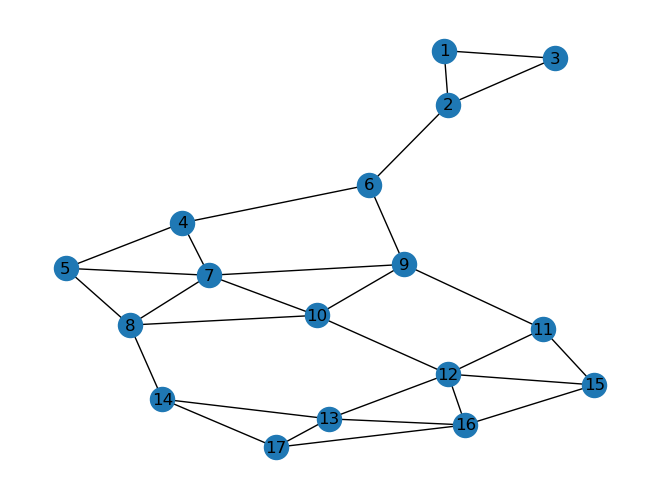

In [12]:
def figure_19_4() -> nx.Graph:
    G = nx.Graph()
    G.add_nodes_from(range(1, 16))
    G.add_edges_from([(1, 2),(1, 3),(2, 3),(2, 6),(4, 5),(4, 6),(4, 7),(5, 7),(5, 8),(6, 9),(7, 8),(7, 9),(7, 10)])
    G.add_edges_from([(8, 10),(8, 14),(9, 10),(9, 11),(10, 12),(11, 12),(11, 15),(12, 13),(12, 15),(12, 16)])
    G.add_edges_from([(13, 14),(13, 16),(13, 17),(14, 17),(15, 16),(16, 17)])

    return G

G = figure_19_4()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: 1 and 2

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


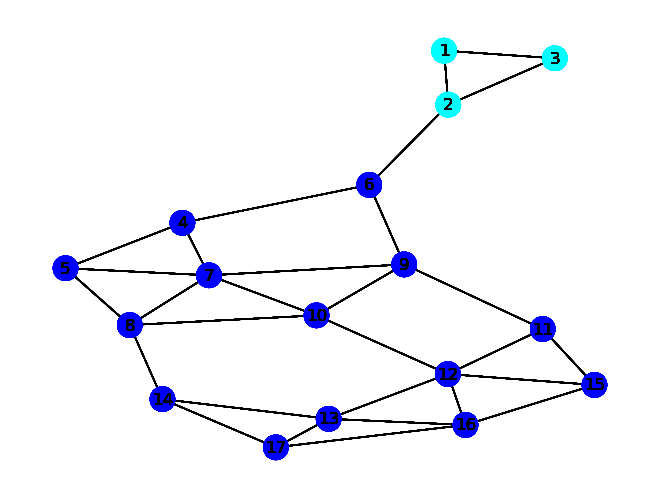

In [13]:
population = Population(figure_19_4, lambda _: [1, 2])
fig_19_4_1_2_sim = Simulation('fig_19_4_1_2', population, layout)
fig_19_4_1_2_sim.run(animate=True)

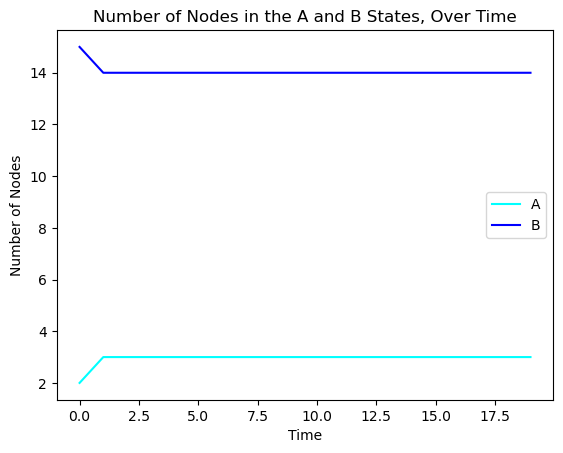

In [14]:
fig_19_4_1_2_sim.plot()

Early adopters: 7 and 8

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


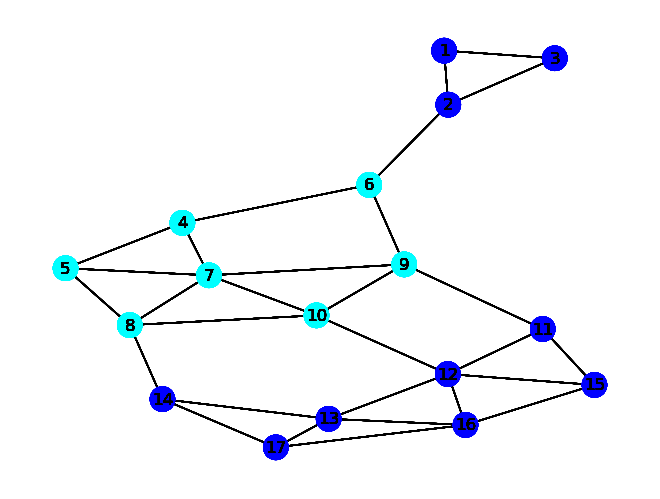

In [15]:
population = Population(figure_19_4, lambda _: [7, 8])
fig_19_4_7_8_sim = Simulation('fig_19_4_7_8', population, layout)
fig_19_4_7_8_sim.run(animate=True)

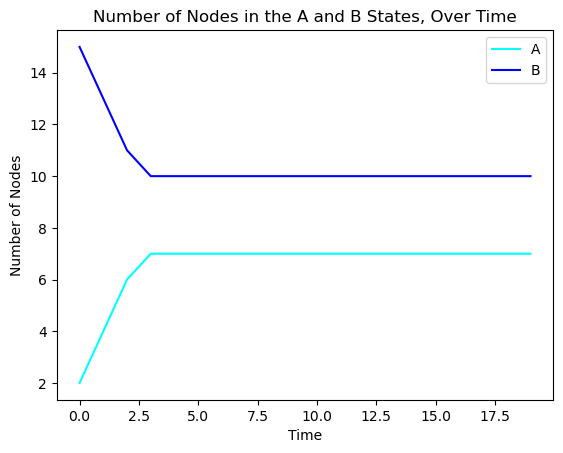

In [16]:
fig_19_4_7_8_sim.plot()

Early adopters: 6, 7, and 12

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


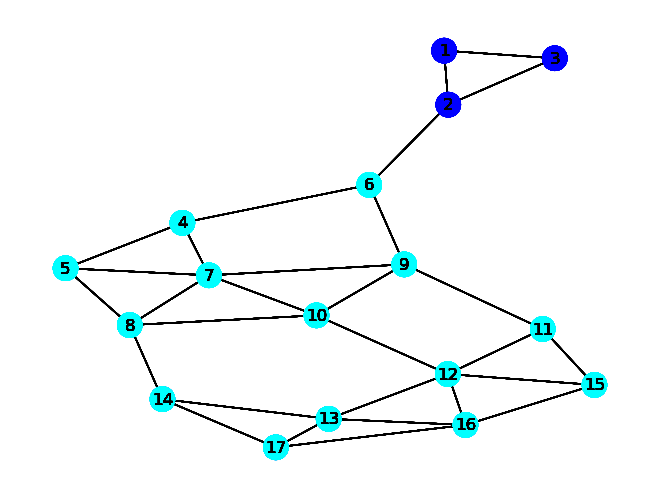

In [17]:
population = Population(figure_19_4, lambda _: [6, 7, 12])
fig_19_4_6_7_12_sim = Simulation('fig_19_4_6_7_12', population, layout)
fig_19_4_6_7_12_sim.run(animate=True)

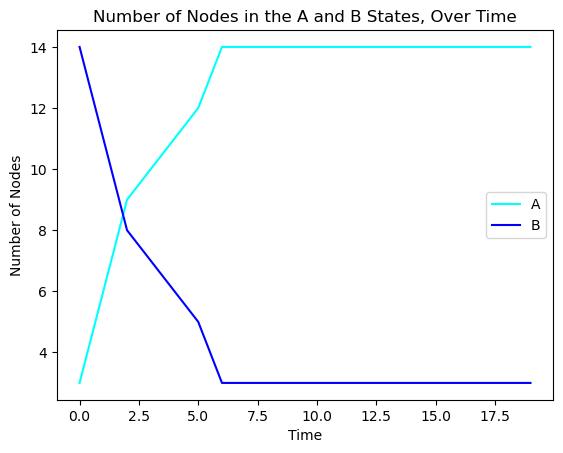

In [18]:
fig_19_4_6_7_12_sim.plot()

### Circulant, 20-2

Hypotheses:

<ul>
    <li> Each node in this graph has four neighbors.  Since a = 3 and b = 2, each node needs two or more of its neighbors to be in the A state in order to adopt A itself.  Since nodes 1 and 2 are immediate neighbors, they will spread A to all of the nodes over time (to 3 and 20, then 4 and 19, etc.).
    <li> For similar reasons as the previous hypothesis, nodes 1 and 10 will not spread A because they are on opposite sides of the graph.
</ul>

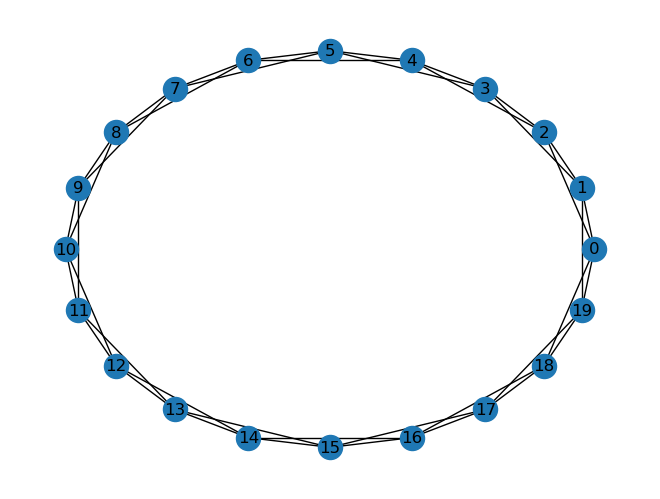

In [19]:
def circulant_20_2() -> nx.Graph:
    return nx.circulant_graph(20, [1, 2])

G = circulant_20_2()
layout = nx.circular_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: 1 and 2

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


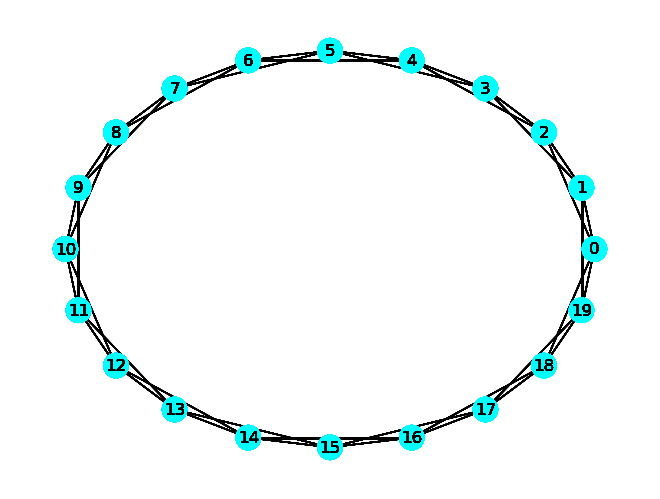

In [20]:
population = Population(circulant_20_2, lambda _: [0, 1])
circulant_20_2_1_2_sim = Simulation('circulant_20_2_1_2', population, layout)
circulant_20_2_1_2_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_circulant_20_2_1_2.gif" align="center">

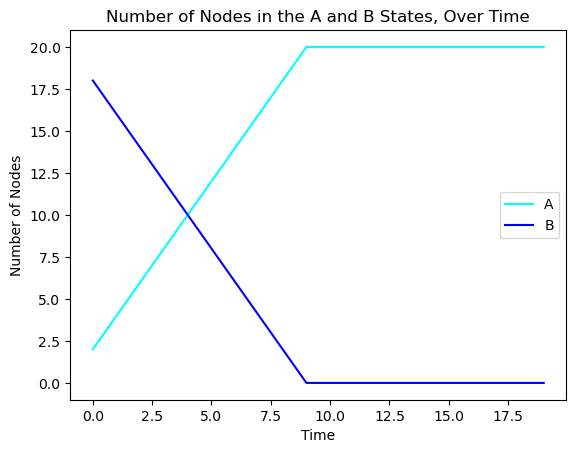

In [21]:
circulant_20_2_1_2_sim.plot()

Early adopters: 1 and 10

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


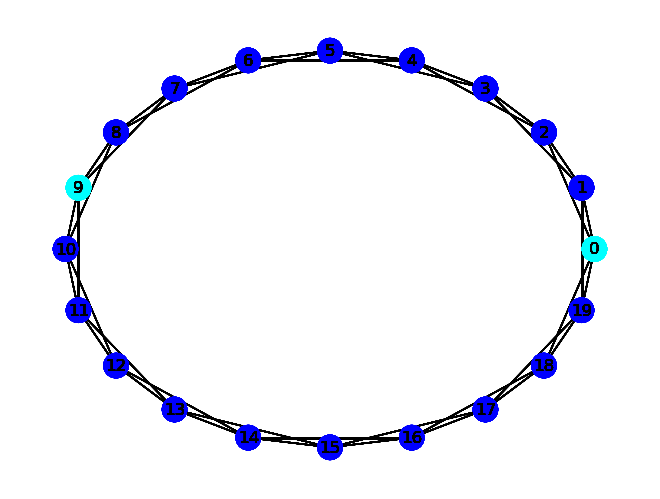

In [22]:
population = Population(circulant_20_2, lambda _: [0, 9])
circulant_20_2_1_10_sim = Simulation('circulant_20_2_1_10', population, layout)
circulant_20_2_1_10_sim.run(animate=True)

Animation (no spread occurs):

<img src="./project_2_animations/animation_circulant_20_2_1_10.gif" align="center">

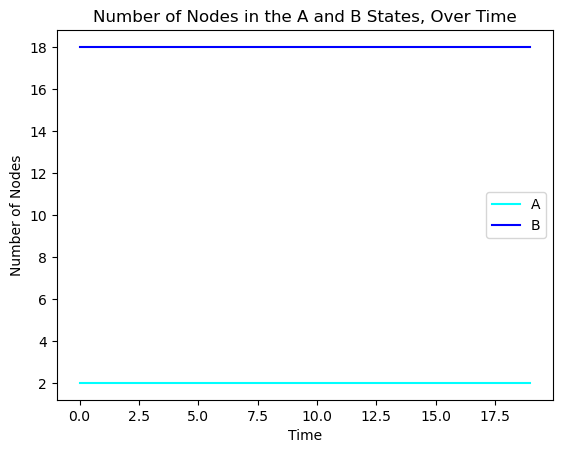

In [23]:
circulant_20_2_1_10_sim.plot()

In [24]:
nx.average_clustering(G)

0.5

Both of my hypotheses were correct (this wasn't too hard, though, because this graph and the next one are very simple).  It appears that the smallest set of adopters that can guarantee a full cascade is the set containing two nodes that are neighbors with each other.  Also note that the clustering coefficient for this graph is 0.5 (it's "not small"), which helps explain the ease of complex contagion spread, assuming the early adopters are next to each other.

### Circulant, 20-4

Hypotheses:
<ul>
    <li> This graph is similar to the previous graph, but now every node has eight neighbors.  This means that nodes must have at least four A neighbors in order to adopt A.  Nodes 1 and 2 will not be sufficient to spread A throughout the network (or to any single node).
    <li> However, nodes 1, 2, 3, and 4 should be sufficient to spread A throughout the network because there are four of them and they are neighbors with each other.
</ul>

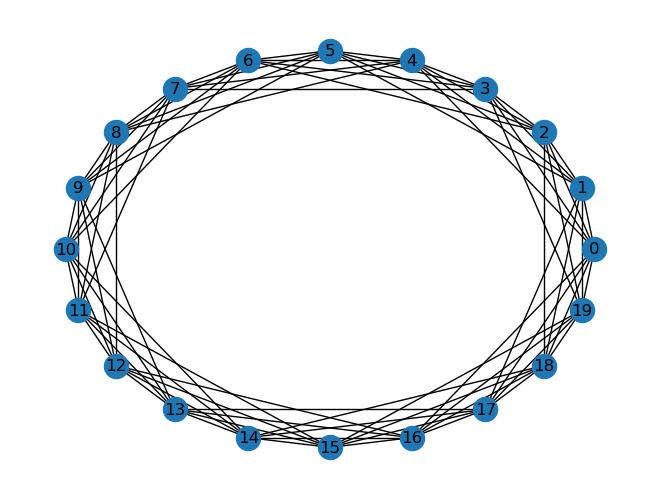

In [25]:
def circulant_20_4() -> nx.Graph:
    return nx.circulant_graph(20, [1, 2, 3, 4])

G = circulant_20_4()
layout = nx.circular_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: 1 and 2

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


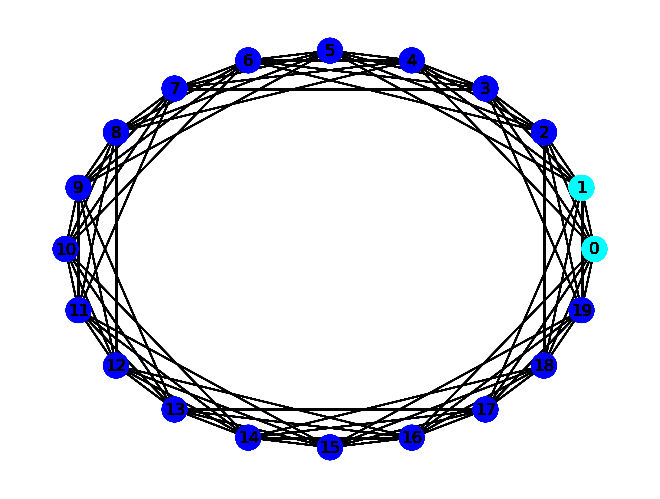

In [26]:
population = Population(circulant_20_4, lambda _: [0, 1])
circulant_20_4_1_2_sim = Simulation('circulant_20_4_1_2', population, layout)
circulant_20_4_1_2_sim.run(animate=True)

Animation (no spread occurs):

<img src="./project_2_animations/animation_circulant_20_4_1_2.gif" align="center">

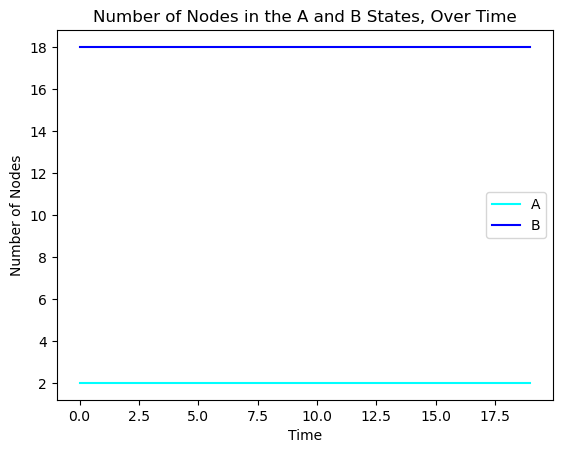

In [27]:
circulant_20_4_1_2_sim.plot()

Early adopters: 1, 2, 3, and 4

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


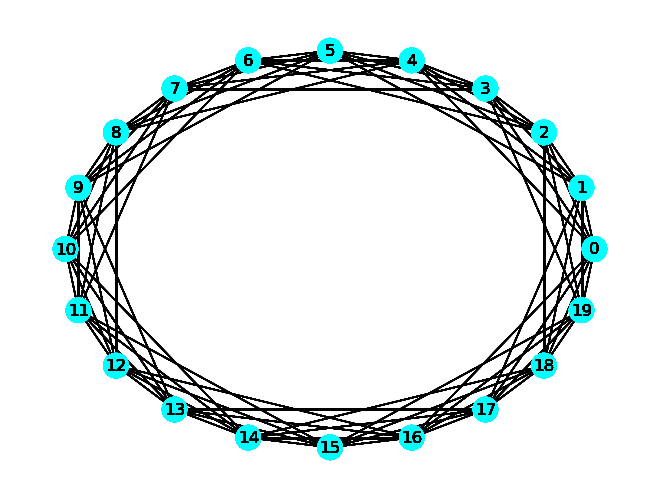

In [28]:
population = Population(circulant_20_4, lambda _: [0, 1, 2, 3])
circulant_20_4_1_2_3_4_sim = Simulation('circulant_20_4_1_2_3_4', population, layout)
circulant_20_4_1_2_3_4_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_circulant_20_4_1_2_3_4.gif" align="center">

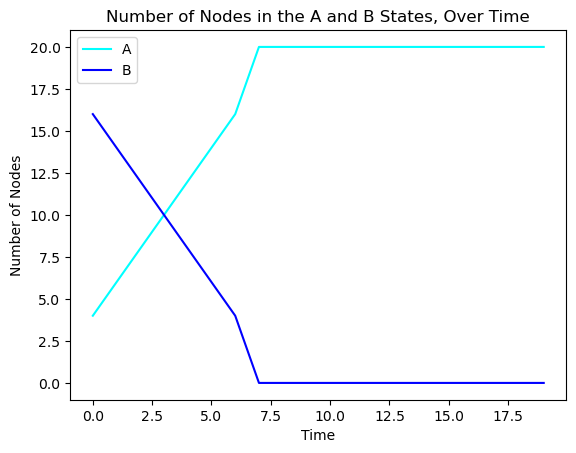

In [29]:
circulant_20_4_1_2_3_4_sim.plot()

In [30]:
nx.average_clustering(G)

0.6428571428571429

Similar to the circulant 20-2 graph, both of my hypotheses were correct (again, this was a simple graph).  It appears that the smallest set of adopters that can guarantee a full cascade is the set containing four nodes that are neighbors with each other.  Also note that the clustering coefficient for this graph is approximately 0.643 (it's "not small"), which, similar to the previous network, helps explain the ease of complex contagion spread, assuming there are proper early adopters.

### Karate

Hypothesis:

In class, we discussed the fact that nodes 1 and 34 represent the leaders of two distinct karate clubs.  Because of this, I hypothesize that full spread will only occur if nodes 1 and 34 are early adopters.


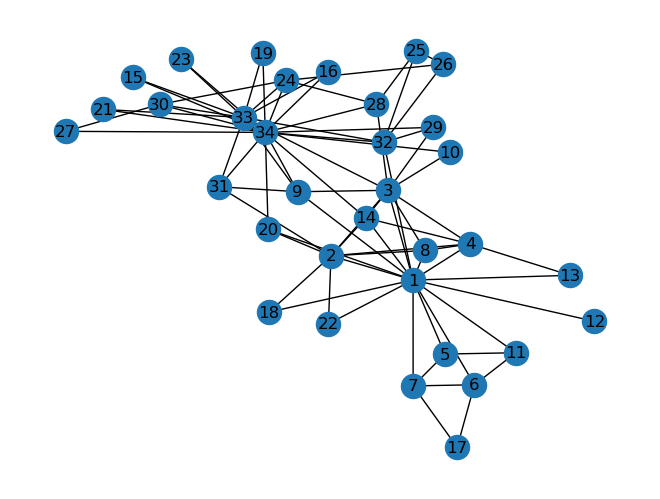

In [31]:
def karate() -> nx.Graph:
    return read_graph_from_file('./project_2_files/karate.mtx')

G = karate()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: 1 and 2

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


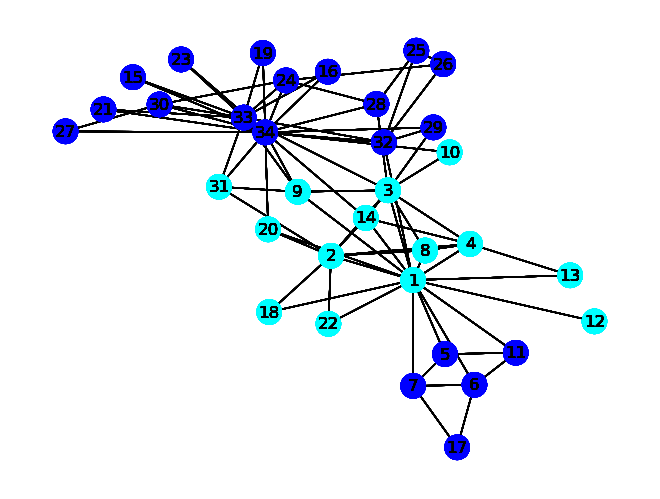

In [32]:
population = Population(karate, lambda _: [1, 2])
karate_1_2_sim = Simulation('karate_1_2', population, layout)
karate_1_2_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_karate_1_2.gif" align="center">

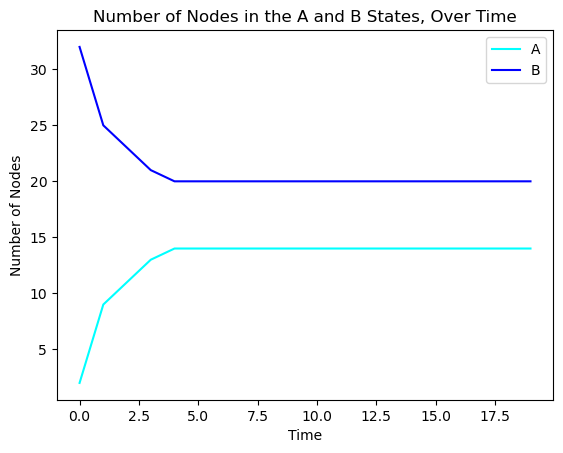

In [33]:
karate_1_2_sim.plot()

Early adopters: 33 and 34

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


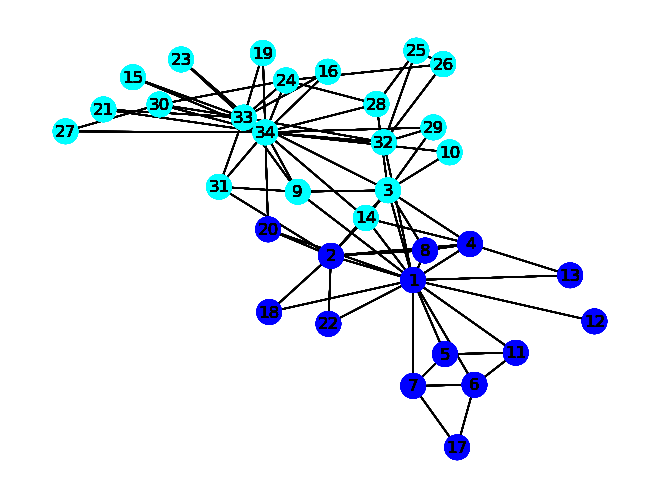

In [34]:
population = Population(karate, lambda _: [33, 34])
karate_33_34_sim = Simulation('karate_33_34', population, layout)
karate_33_34_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_karate_33_34.gif" align="center">

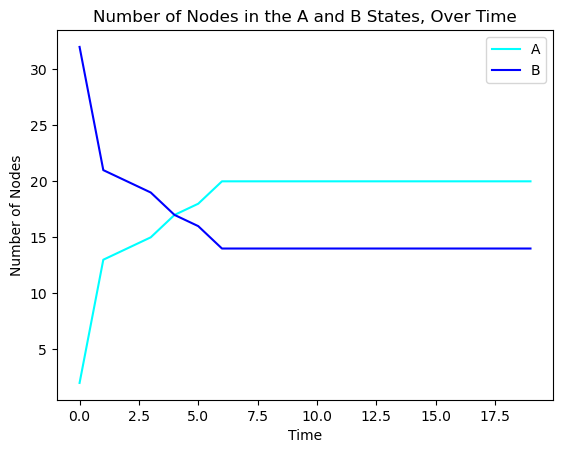

In [35]:
karate_33_34_sim.plot()

Early adopters: 1 and 34

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


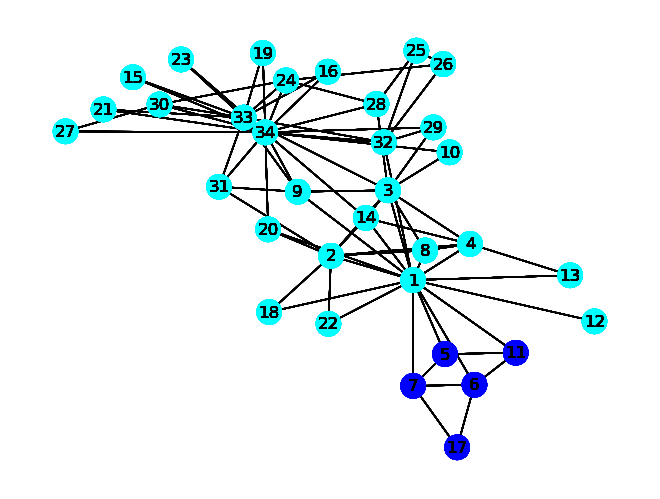

In [36]:
population = Population(karate, lambda _: [1, 34])
karate_1_34_sim = Simulation('karate_1_34', population, layout)
karate_1_34_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_karate_1_34.gif" align="center">

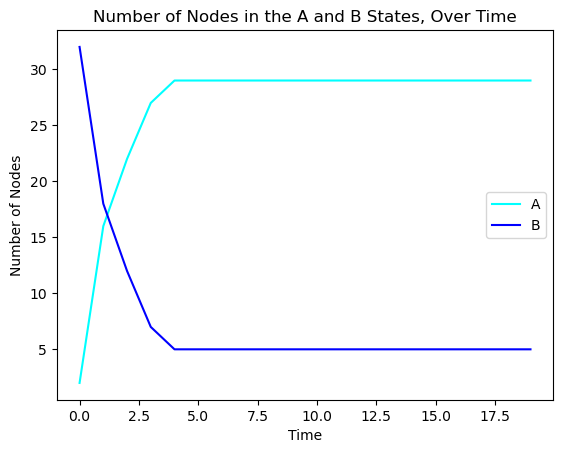

In [37]:
karate_1_34_sim.plot()

Early adopters: 1, 5, and 34

MovieWriter imagemagick unavailable; using Pillow instead.


Done with simulations; animating...


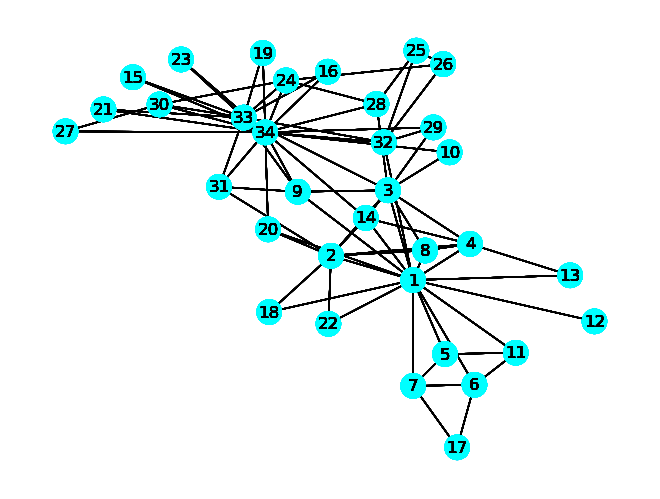

In [38]:
population = Population(karate, lambda _: [1, 5, 34])
karate_1_5_34_sim = Simulation('karate_1_5_34', population, layout)
karate_1_5_34_sim.run(animate=True)

Animation:

<img src="./project_2_animations/animation_karate_1_5_34.gif" align="center">

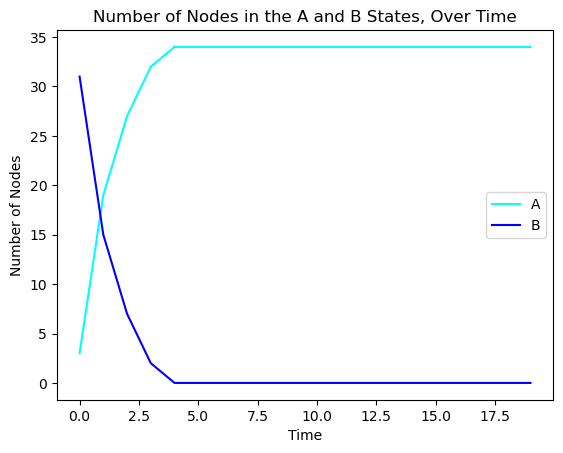

In [39]:
karate_1_5_34_sim.plot()

In [40]:
clustering_coefficients(G)

Clustering coefficients:
Node 1: 0.15
Node 2: 0.3333333333333333
Node 3: 0.24444444444444444
Node 4: 0.6666666666666666
Node 5: 0.6666666666666666
Node 6: 0.5
Node 7: 0.5
Node 8: 1.0
Node 9: 0.5
Node 10: 0
Node 11: 0.6666666666666666
Node 12: 0
Node 13: 1.0
Node 14: 0.6
Node 15: 1.0
Node 16: 1.0
Node 17: 1.0
Node 18: 1.0
Node 19: 1.0
Node 20: 0.3333333333333333
Node 21: 1.0
Node 22: 1.0
Node 23: 1.0
Node 24: 0.4
Node 25: 0.3333333333333333
Node 26: 0.3333333333333333
Node 27: 1.0
Node 28: 0.16666666666666666
Node 29: 0.3333333333333333
Node 30: 0.6666666666666666
Node 31: 0.5
Node 32: 0.2
Node 33: 0.19696969696969696
Node 34: 0.11029411764705882


In [41]:
katz_centrality(G)

Katz centrality:
Node 1: 0.3213245969592325
Node 2: 0.2354842531944946
Node 3: 0.2657658848154288
Node 4: 0.1949132024917254
Node 5: 0.12190440564948413
Node 6: 0.1309722793286492
Node 7: 0.1309722793286492
Node 8: 0.166233052026894
Node 9: 0.2007178109661081
Node 10: 0.12420150029869696
Node 11: 0.12190440564948413
Node 12: 0.09661674181730141
Node 13: 0.11610805572826272
Node 14: 0.19937368057318847
Node 15: 0.12513342642033795
Node 16: 0.12513342642033795
Node 17: 0.09067874388549631
Node 18: 0.12016515915440099
Node 19: 0.12513342642033795
Node 20: 0.15330578770069542
Node 21: 0.12513342642033795
Node 22: 0.12016515915440099
Node 23: 0.12513342642033795
Node 24: 0.16679064809871574
Node 25: 0.11021106930146936
Node 26: 0.11156461274962841
Node 27: 0.11293552094158042
Node 28: 0.1519016658208186
Node 29: 0.143581654735333
Node 30: 0.15310603655041516
Node 31: 0.16875361802889585
Node 32: 0.19380160170200547
Node 33: 0.2750851434662392
Node 34: 0.3314063975218936


In [42]:
nx.average_clustering(G)

0.5706384782076823

My hypothesis was almost correct; nodes 1 and 34 almost created a complete spread, but the nodes 5, 6, 7, 11, and 17 were unaffected.  Nonetheless, nodes 1 and 34 do seem to be key to promoting a complete cascade.  Their clustering coefficients are approximately 0.15 and 0.11, respectively, which, in my opinion, don't really help with understanding why they are important.  However, they have the two largest Katz centrality metrics in the network (approximately 0.32 and 0.33, respectively); I think this helps paint a clearer picture as to why they are influential.  So, it appears that the smallest set of adopters that can guarantee a full cascade is the three-node set containing nodes 1 and 34, in addition to either node 5, 6, 7, 11, or 17.  Finally, we can see that complex contagion can spread effectively on this graph; its clustering coefficient is approximately 0.571 (not small), which makes sense.

### Small World, 100

Hypotheses:

<ul>
    <li> We discussed in class that small-world networks do not promote the spread of complex contagion.  The reasoning for this was that complex contagion requires high clustering (as we've seen with the previous graphs) and strong ties (edges within clusters).  If there are weak ties (edges between clusters), complex contagion can be blocked.  Using the two conditions for a small-world graph, we have a high clustering coefficient but a good amount of weak ties.  Because of this, I hypothesize that there will be little spread when the early adopters are the four nodes with lowest degree.
    <li> Similar to the previous hypothesis, I hypothesize that complex contagion will spread more under the four nodes with the highest degree, but will still not be as extreme as we've seen with the previous networks.
</ul>

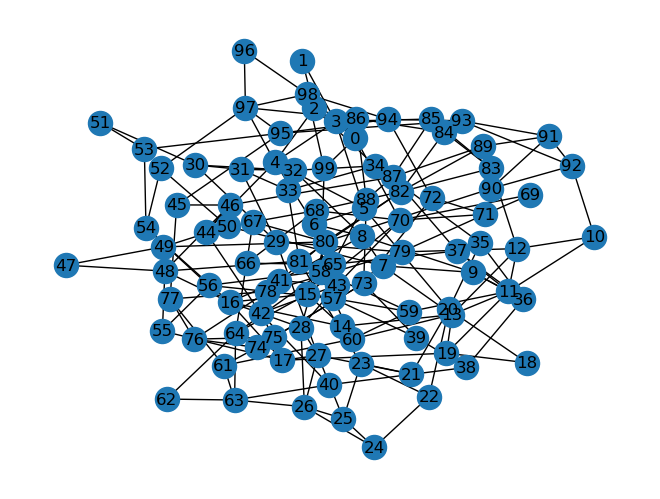

In [43]:
def small_world_100() -> nx.Graph:
    return nx.watts_strogatz_graph(100, 5, 0.3)

G = small_world_100()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: The four nodes with the lowest degree

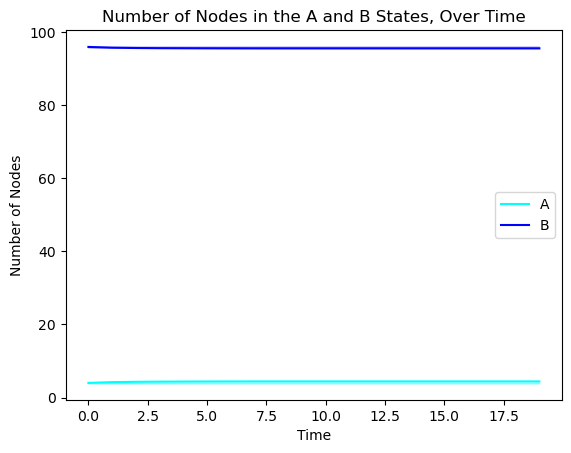

In [44]:
population = Population(small_world_100, lambda graph: lowest_highest_n_degree(graph, 4))
small_world_100_lowest_sim = Simulation('small_world_100_lowest_4', population, layout, n_trials=100)
small_world_100_lowest_sim.run()
small_world_100_lowest_sim.plot(show_iqr=True)

Early adopters: The four nodes with the highest degree

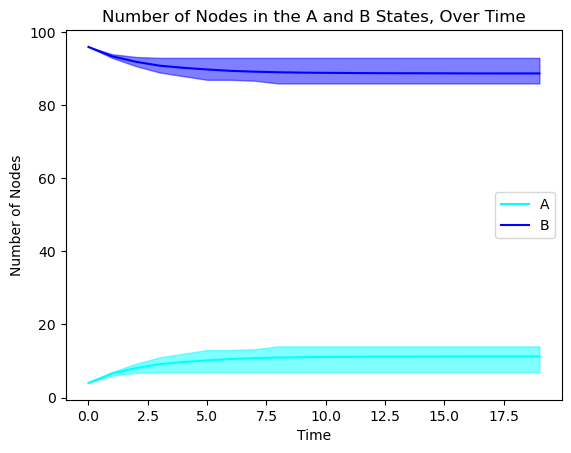

In [45]:
population = Population(small_world_100, lambda graph: lowest_highest_n_degree(graph, 4, lowest=False))
small_world_100_highest_sim = Simulation('small_world_100_highest_4', population, layout, n_trials=100)
small_world_100_highest_sim.run()
small_world_100_highest_sim.plot(show_iqr=True)

In [46]:
nx.average_clustering(G)

0.16190476190476188

It looks like both of my hypotheses were correct, but I was still surprised by how little spread there was (I thought that the four nodes with the highest degree would have a stronger influence than they did).  The clustering coefficient for this graph is approximately 0.162.  This feels small to me (i.e. it's not "not small"), but I used nx.watts_strogatz_graph(100, 5, 0.3) to generate the network, as instructed in the project specs.  Nonetheless, the small clustering coefficient is perhaps still a good indicator as to why complex contagion did not spread well for this graph.

### Scale-Free, 100

Hypotheses:

<ul>
    <li> I think of scale-free networks as "the rich get richer" phenomenon, as we've also discussed in class.  If the four nodes with the smallest degree are used as early adopters, I would guess that complex contagion wouldn't spread well because these can be viewed as the poorest individuals in society, and the poor, unfortunately, have little influence.
    <li> If the four nodes with the highest degree are early adopters, then I would guess that most, if not all, of the network adopts A.  This is because these nodes can be viewed as the wealthiest individuals in society, so they possess strong influence over what others do.
</ul>

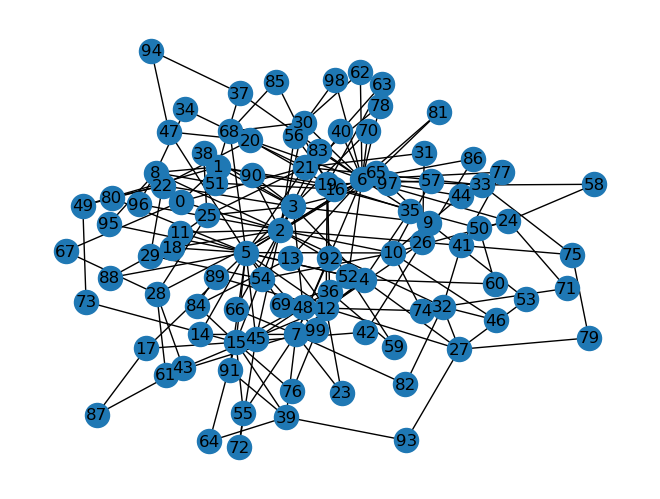

In [48]:
def scale_free_100() -> nx.Graph:
    return nx.barabasi_albert_graph(100, 2)

G = scale_free_100()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: The four nodes with the lowest degree

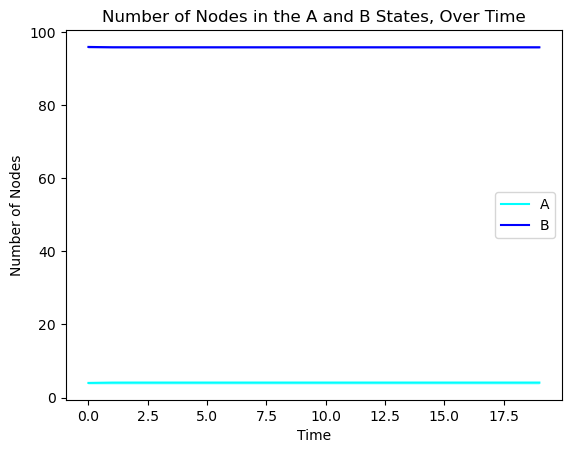

In [49]:
population = Population(scale_free_100, lambda graph: lowest_highest_n_degree(graph, 4))
scale_free_100_lowest_sim = Simulation('scale_free_100_lowest_4', population, layout, n_trials=100)
scale_free_100_lowest_sim.run()
scale_free_100_lowest_sim.plot(show_iqr=True)

Early adopters: The four nodes with the highest degree

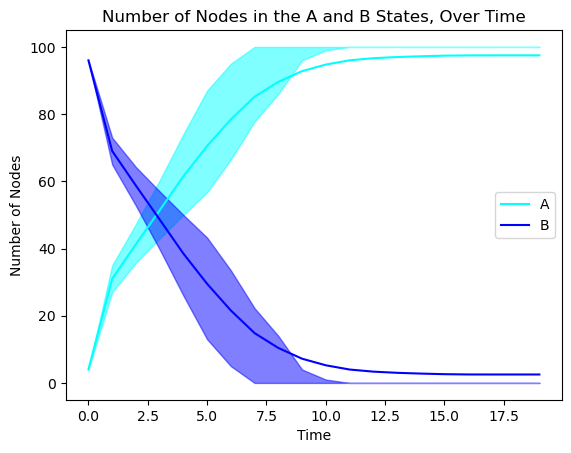

In [50]:
population = Population(scale_free_100, lambda graph: lowest_highest_n_degree(graph, 4, lowest=False))
scale_free_100_highest_sim = Simulation('scale_free_100_highest_4', population, layout, n_trials=100)
scale_free_100_highest_sim.run()
scale_free_100_highest_sim.plot(show_iqr=True)

In [51]:
nx.average_clustering(G)

0.10256683375104428

It looks like both of my hypotheses were correct, though I'm somewhat suprised that, on average, not everyone adopted A when the four highest-degree nodes were early adopters.  The clustering coefficient for this graph is approximately 0.103, which I think is small.  Similar to what we saw in the small-world network, it appears that complex contagion struggles in this graph, unless the most influential "members of society" are early adopters.  A general pattern I'm noticing is that clustering isn't the entire picture; it seems that which nodes are early adopters can have a significant impact on spread.

### Small World, 410

Hypothesis:

We're only testing the outcome when the twenty nodes with the largest degree are early adopters.  Similar to my hypotheses and results for the small-world 100 graph, I'm guessing that spread will be very small.

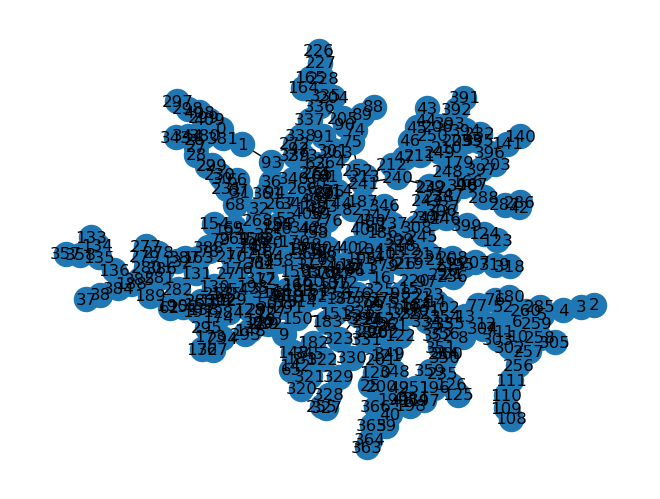

In [52]:
def small_world_410() -> nx.Graph:
    return nx.watts_strogatz_graph(410, 3, 0.3)

G = small_world_410()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: The twenty nodes with the highest degree

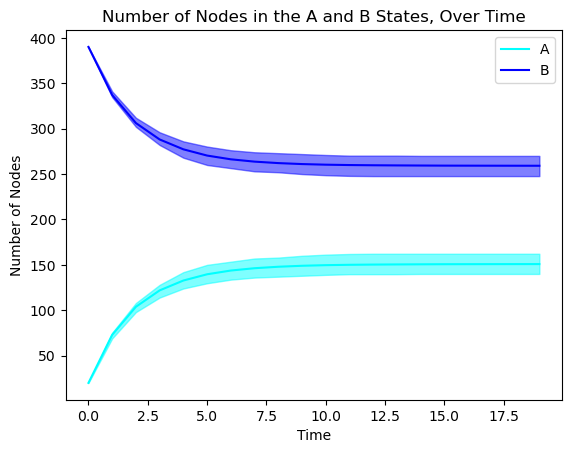

In [53]:
population = Population(small_world_410, lambda graph: lowest_highest_n_degree(graph, 20, lowest=False))
small_world_410_highest_sim = Simulation('small_world_410_highest_20', population, layout, n_trials=100)
small_world_410_highest_sim.run()
small_world_410_highest_sim.plot(show_iqr=True)

In [54]:
nx.average_clustering(G)

0.0

I would probably say that my hypothesis was incorrect for this scenario.  While spread wasn't drastic, it appears that roughly one third of the population still adopted A (so, I would say that spread was at least somewhat significant).  This is very interesting, considering what we saw in the small world 100 graph and the fact that the clustering coefficient for this graph is approximately 0.  I'm not really sure why this would be the case, other than maybe we have enough early adopters and they are influential enough to generate a decent spread.  However, this does seem like additional evidence that clustering is just a factor and doesn't paint the entire picture.

### Scale-Free, 410

Hypotheses:

<ul>
    <li> Similar to the scale-free 100 network, I'm guessing that the twenty nodes with the highest degree will spread A to most, if not all, of the network.
    <li> When the fifty nodes with the highest degree are early adopters, I'm guessing that spread will be faster than the twenty-node case.
</ul>

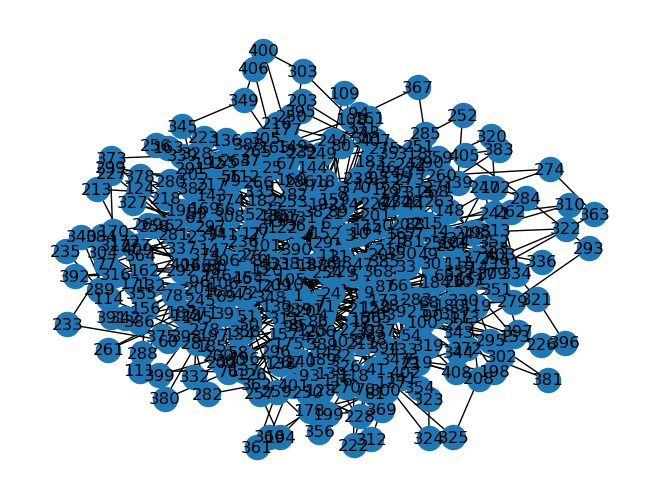

In [55]:
def scale_free_410() -> nx.Graph:
    return nx.barabasi_albert_graph(410, 2)

G = scale_free_410()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: The twenty nodes with the highest degree

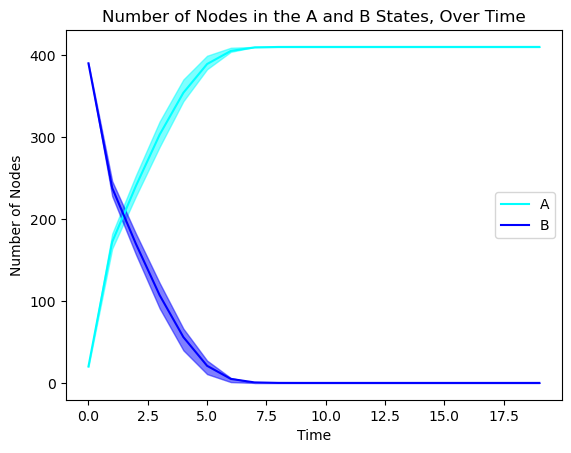

In [56]:
population = Population(scale_free_410, lambda graph: lowest_highest_n_degree(graph, 20, lowest=False))
scale_free_410_highest_sim = Simulation('scale_free_410_highest_20', population, layout, n_trials=100)
scale_free_410_highest_sim.run()
scale_free_410_highest_sim.plot(show_iqr=True)

Early adopters: The fifty nodes with the highest degree

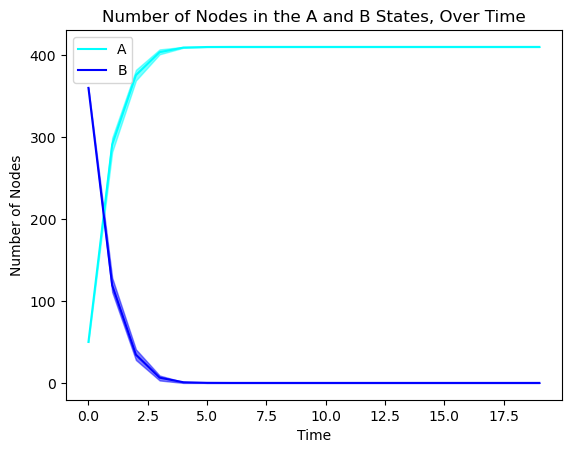

In [57]:
population = Population(scale_free_410, lambda graph: lowest_highest_n_degree(graph, 50, lowest=False))
scale_free_410_highest_50_sim = Simulation('scale_free_410_highest_50', population, layout, n_trials=100)
scale_free_410_highest_50_sim.run()
scale_free_410_highest_50_sim.plot(show_iqr=True)

In [58]:
nx.average_clustering(G)

0.04312260110659863

Of the larger networks, this one was probably the easiest to hypothesize about, especially after seeing the results from the scale-free 100 graph.  Again, the clustering coefficient is small (about 0.043), but we see that, as long as nodes representing the most influential members of society are early adopters, complex contagion spreads relatively easily and, in both cases for this graph, to the entire network.  We can also see that spread was faster (the max number of adopters was reached in fewer time steps) when the fifty highest-degree nodes were early adopters (i.e. more of the bourgeoisie were early adopters).

### Dublin

Hypothesis:

We're only looking at the scenario where the fifty nodes with highest degree are early adopters.  From the Dublin network's description (using the link we were given for project 1), the clustering coefficient is approximately 0.456, which is not small.  Furthermore, considering that, similar to the scale-free 410 results, we're using the fifty most influential nodes, I would guess that complex contagion will spread to most, if not all, of the network.

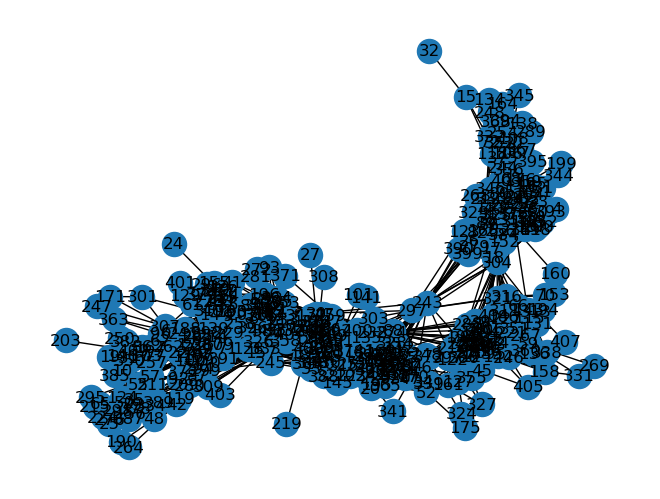

In [60]:
def dublin() -> nx.Graph:
    return read_graph_from_file('./project_2_files/ia-infect-dublin.mtx')

G = dublin()
layout = nx.spring_layout(G)
nx.draw(G, layout, with_labels=True)
plt.show()

Early adopters: The fifty nodes with the highest degree

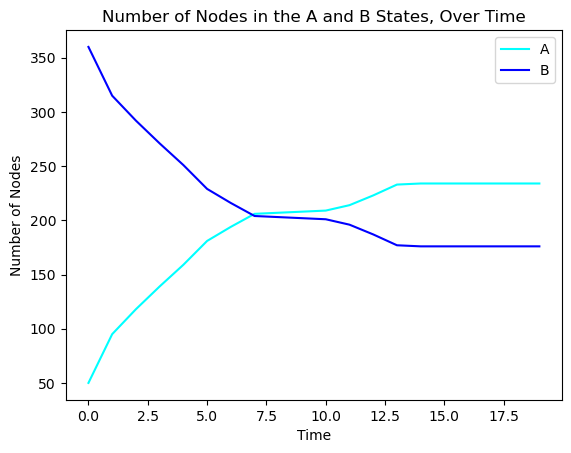

In [61]:
population = Population(dublin, lambda graph: lowest_highest_n_degree(graph, 50, lowest=False))
dublin_highest_50_sim = Simulation('dublin_highest_50', population, layout, n_trials=1)
dublin_highest_50_sim.run()
dublin_highest_50_sim.plot()

In [62]:
nx.average_clustering(G)

0.45582424184357145

I would say that my hypothesis was incorrect.  I thought that A would spread to nearly all of the network; while it spread to more than half of the nodes, the spread wasn't as extreme as I thought it would be.  I'm not sure why, because the clustering coefficient is not small and the early adopters were influential.

### Summary Plots (For the Large Networks)

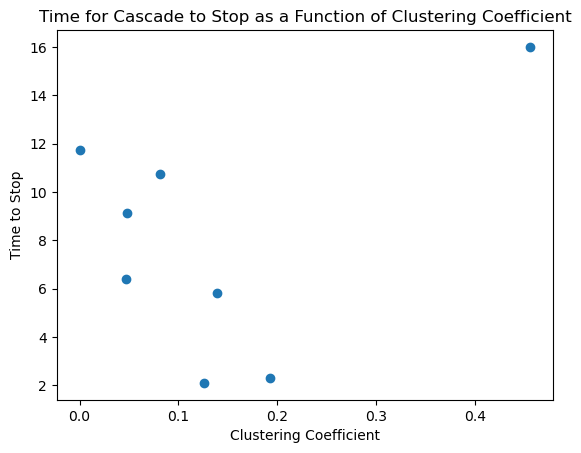

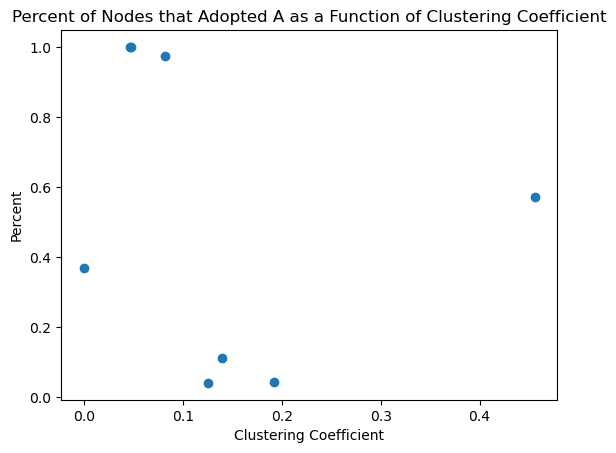

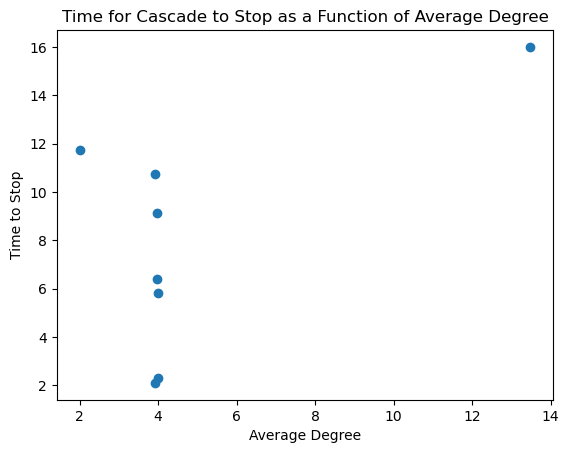

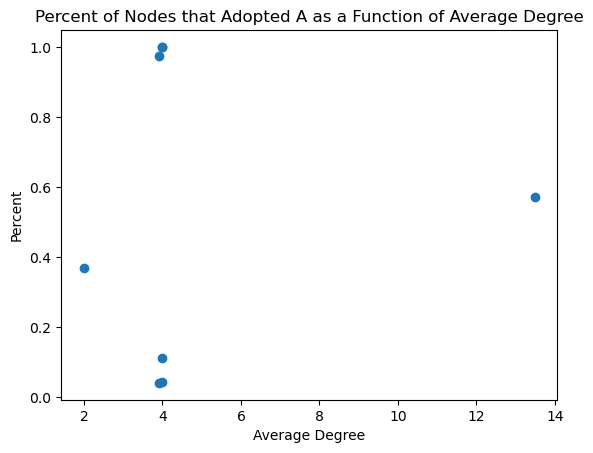

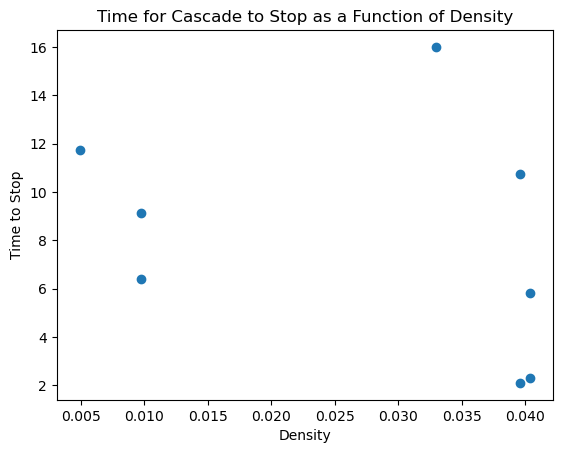

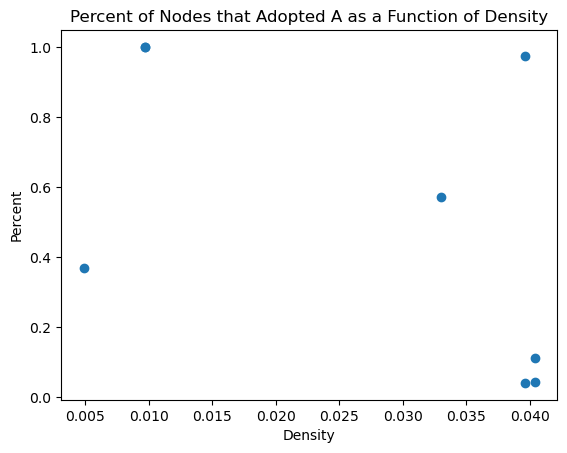

In [80]:
simulations = [small_world_100_lowest_sim, small_world_100_highest_sim, scale_free_100_lowest_sim, 
               scale_free_100_highest_sim, small_world_410_highest_sim, scale_free_410_highest_sim, 
               scale_free_410_highest_50_sim, dublin_highest_50_sim]

plots_for_larger_graphs(simulations)

I personally didn't find any of these graphs to be particularly useful because, as I noted in my hypotheses and discussions, it seems like there's a variety of factors that influence complex contagion, such as clustering coefficient, which nodes are early adopters, strong vs. weak ties, etc.  However, I included them as part of the project requirements.  The only graph I found to be somewhat interesting/useful is the first graph, which shows the time to convergence as a function of clustering coefficient.  It seems that, with the exception of one outlier, the time to stop decreases as clustering coefficient increases.  One could maybe make similar arguments for the percent of adopted nodes as a function of clustering coefficient (second graph) and the percent of adopted nodes as a function of density (final graph).

### Summary Table (For the Large Networks)

In [73]:
simulations = [small_world_100_lowest_sim, small_world_100_highest_sim, scale_free_100_lowest_sim, 
               scale_free_100_highest_sim, small_world_410_highest_sim, scale_free_410_highest_sim, 
               scale_free_410_highest_50_sim, dublin_highest_50_sim]

summary_table(simulations)

Summary table, where values are rounded to 3 decimal places:
                        Graph  Time to Stop, 25th Percentile  Time to Stop, Average  Time to Stop, 75th Percentile  Adoption Percentage, 25th Percentile  Adoption Percentage, Average  Adoption Percentage, 75th Percentile  Clustering Coefficient  Average Degree  Density
0    small_world_100_lowest_4                           2.00                   2.32                            2.0                                 0.040                         0.044                                 0.040                   0.192           4.000    0.040
1   small_world_100_highest_4                           3.75                   5.84                            7.0                                 0.070                         0.113                                 0.140                   0.139           4.000    0.040
2     scale_free_100_lowest_4                           2.00                   2.10                            2.0               

### Future Work

If I had more time I would work on creating better summary plots for the larger networks (I didn't find them particularly useful).  I also would have tried to analyze the small world 410 and Dublin graphs a little more, as their results surprised me the most.